# Exemple d'utilisation des fonctions de cartographie pour la production de cartes à  partir de données Greenguard / Aquacheck

On commence par importer les libraries nécessaires, et les fonctions de cartographie.

In [1]:
import numpy as np
import pandas as pd
import cartographie
import datetime

## Chargement des fichiers

Les fichiers sont chargés dans lma cellule ci-dessous. Il s'agit des fichiers textes produits par les stations. On renseigne également la localisation de chaque station.

In [2]:
files = [
    "./data/batens.txt", # sortie de chaque station
    "./data/logistique.txt",
    "./data/potager.txt", 
    "./data/dmsm.txt"  
]

X = np.array([
    [43.566109, 1.474284], # lat, lon pour chaque station
    [43.536898, 1.471903],
    [43.570674, 1.470595],
    [43.571984, 1.470783]
])

all_data = [pd.read_csv(f, names=["date", "humidity", "temperature", "soil_moisture", "humidity_percentage"], skiprows=1) for f in files]
all_data[0].head()

,date,humidity,temperature,soil_moisture,humidity_percentage
0,March 01 2025 07:46:00,50.418854,20.221519,3551,1.164179
1,March 01 2025 08:47:16,49.496746,9.056282,3136,13.552238
2,March 01 2025 08:48:17,48.847866,8.928871,1107,74.119400
3,March 01 2025 08:49:17,48.309994,8.987236,994,77.492538
4,March 01 2025 08:50:17,47.884750,9.244156,975,78.059700


## Nettoyage des données

## Mise en forme des données

On commence par changer le format de date pour pouvoir les manipuler plus facilement aver datetime.

In [3]:
def convert_datetime(date_str):
    # convert date string to datetime object
    # date_str: date string in the format "Month Day Year Hour:Minute:Second"
    
    # read and separe elements
    month, day, year, hr_str = date_str.split() 
    hh, mm, ss = hr_str.split(":")
    
    # convert month to number
    if month == "January":
        month = 1
    elif month == "February":
        month = 2
    elif month == "March":
        month = 3
    elif month == "April":
        month = 4
    elif month == "May":
        month = 5
    elif month == "June":
        month = 6
    elif month == "July":
        month = 7
    elif month == "August":
        month = 8
    elif month == "September":
        month = 9
    elif month == "October":
        month = 10
    elif month == "November":
        month = 11
    elif month == "December":
        month = 12
    else:
        raise ValueError("Invalid month")
    
    # convert to int
    day, year, hh, mm, ss = map(int, [day, year, hh, mm, ss])
    
    return datetime.datetime(year, month, day, hh, mm)

for i in range(len(all_data)):
    all_data[i]["date"] = all_data[i]["date"].apply(convert_datetime)
all_data[0].head()

,date,humidity,temperature,soil_moisture,humidity_percentage
0,2025-03-01 07:46:00,50.418854,20.221519,3551,1.164179
1,2025-03-01 08:47:00,49.496746,9.056282,3136,13.552238
2,2025-03-01 08:48:00,48.847866,8.928871,1107,74.119400
3,2025-03-01 08:49:00,48.309994,8.987236,994,77.492538
4,2025-03-01 08:50:00,47.884750,9.244156,975,78.059700


On met ensuite en forme les données pour le programme de cartographie. Les séries temporelles doivent avoir le même pas de temps et la même taille. On séletionne donc la période de temps sur laquelle toutes les données sont disponibles.

NB. Ici, le pas de temps est 1min. Avec une fréquence de mesure plus lente, il faudrait arrondir (eg. à la dixaine de minute) au moment de la conversion des dates.

In [11]:
field = "temperature" # champ à tracer
rate = 1 # taux de sous-échantillonnage

# Création des tableaux y et dates
y = [[] for _ in range(len(all_data))]
dates = []
for j in range(len(all_data[0])):
    date_j = all_data[0].date.iloc[j]
    valid = True
    for i in range(len(all_data)):
        if date_j not in all_data[i].date.values:
            valid = False
    if valid:
        if j%rate == 0:
            dates.append(date_j)
            for i in range(len(all_data)):
                y[i].append(all_data[i][all_data[i].date == date_j][field].iloc[0])
y = np.array(y)
dates = np.array(dates)
y.shape, dates.shape


((4, 181), (181,))

## Cartographie

On appelle ensuite les fonctions de cartographie. On commence par tracer une carte pour un pas de temps choisi.

Pour cela, on commence par interpoler les données à l'aide d'une méthode gaussienne (on peut jouer sur le paramètre epsilon pour définir la sphère d'influence de chaque mesure). Pour plus de détails, colsulter la documentation de l'interpolateur utilisé: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html

In [12]:
lats = np.linspace(43.563, 43.5735, 100)
lons = np.linspace(1.470, 1.4785, 100)
lons, lats = np.meshgrid(lons, lats)

t = 0 # pas de temps choisi
epsilon = 300 # sphère d'inflience de chaque mesure 

grid_t = cartographie.interpolate_map(X, y[:, t], lats, lons, epsilon=epsilon)
grid_t.shape

(100, 100)

On trace ensuite la carte des données interpolées.

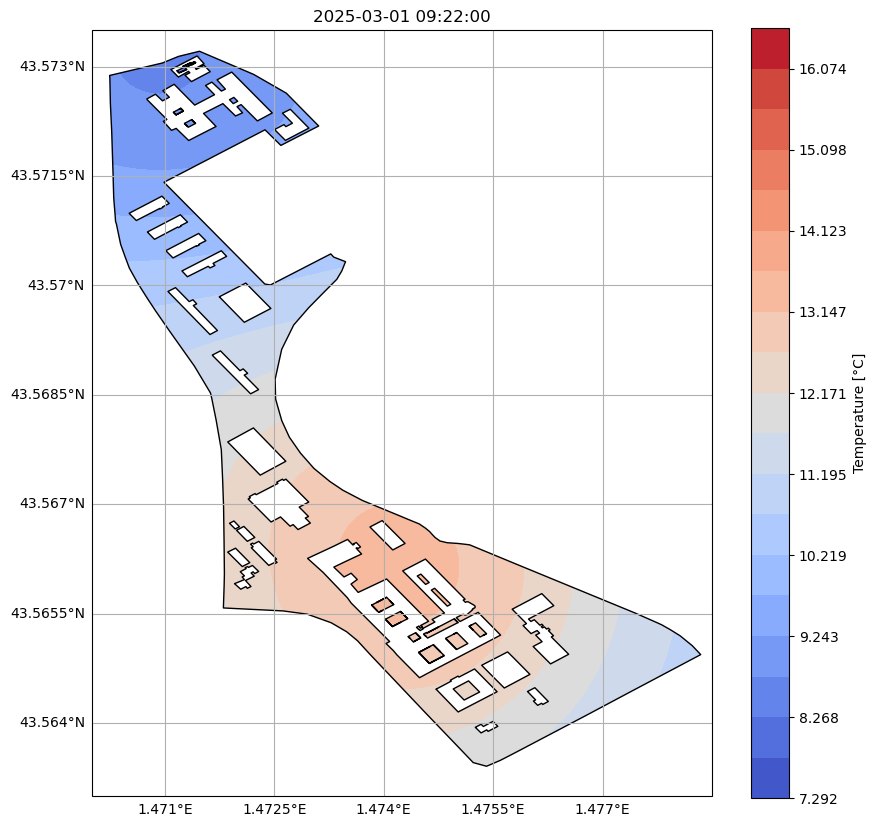

In [13]:
filename = "temperature_map.png" # nom du fichier de sortie
vmin, vmax = y.min(), y.max() # valeurs min et max pour la colorbar
cartographie.plot_map(lats, lons, grid_t, filename, vmin=vmin, vmax=vmax, timestamp=dates[t])

De même, on réalise une carte des données en moyenne temporelle.

In [14]:
grid_m = cartographie.interpolate_map(X, y.mean(axis=1), lats, lons, epsilon=epsilon)
grid_m.shape

(100, 100)

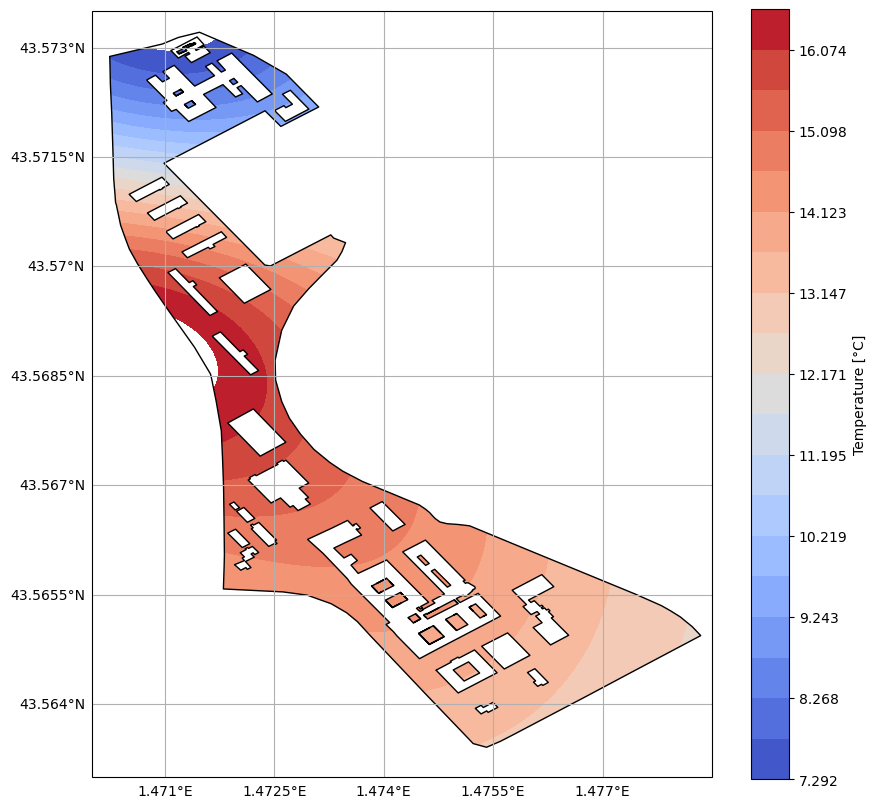

In [15]:
filename = "mean_temperature_map.png" # nom du fichier de sortie
vmin, vmax = y.min(), y.max() # valeurs min et max pour la colorbar
cartographie.plot_map(lats, lons, grid_m, filename, vmin=vmin, vmax=vmax)

Enfin, on réalise une animation. Cette étape est un peu plus longue.

MovieWriter ffmpeg unavailable; using Pillow instead.


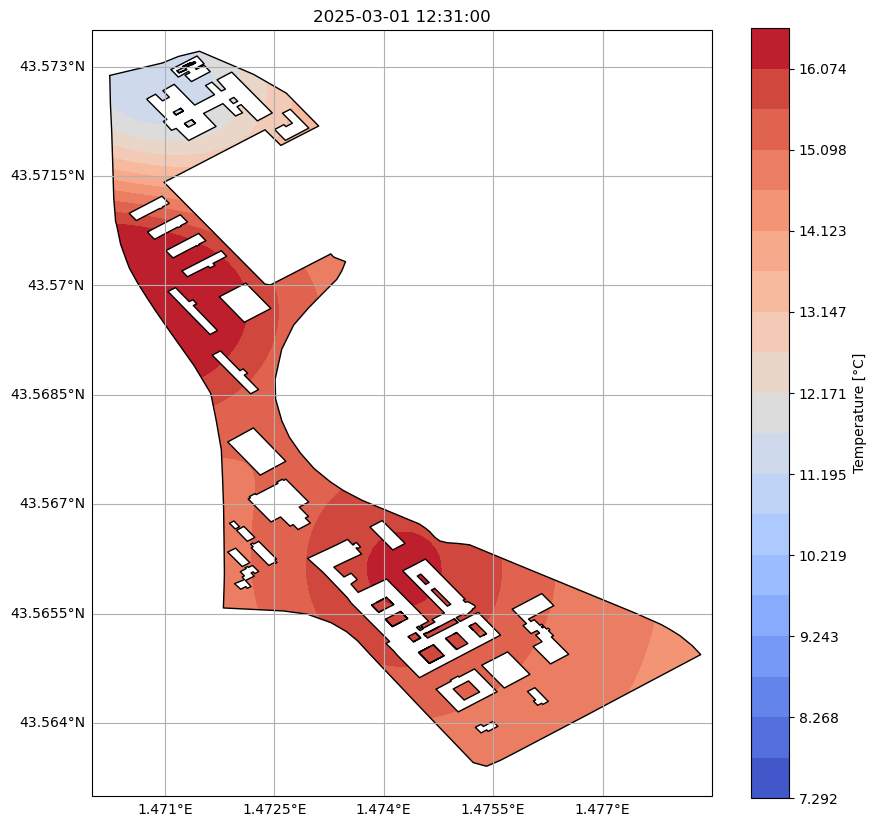

In [16]:
cartographie.plot_animation(X, y, lats, lons, "temperature_animation.gif", epsilon=epsilon, dates=dates)